# KEY: Bag of Words Models

---
In this notebook, we'll use these feature vectors we constructed in the text pre-processing notebook to develop and test a predictive model.

Goals are as follows:

- Fully implement a bag of words model
- Explain the model's predictions
- Continue to gain experience with the model development process
- Explore how hyperparameter settings affect performance

We'll begin by importing the usual libraries in addition to `requests`, which will help us load the dataset from url. Later on, we'll also import a new one, the **natural language toolkit (nltk)**, which will help us preprocess our text data.

- numpy for efficient math operations
- pandas for data and dataframe manipulations
- matplotlib for visualization/plotting
- requests to load data from url
- **nltk for text pre-processing**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

!pip install nltk
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

sw = set(stopwords.words('english'))
ps = PorterStemmer()

[nltk_data] Downloading package punkt to /Users/mme4/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mme4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/mme4/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load and preprocess the dataset

In the following block, we'll prepare the PubMed 200k RCT dataset for model development. Please review the [text preprocessing notebook](https://github.com/engelhard-lab/collaborative-ml-notebooks/blob/main/notebooks/text_preprocessing.ipynb) if/as needed to understand this process. **Please note that this block may take a few minutes to run.**

Steps:
1. Load and tokenize all sentences (train, val, test)
2. Create the vocabulary (**note: you may want to revisit this part later on**)
3. Create features based on the sentences + vocabulary

In [2]:
# STEP ONE: LOAD AND TOKENIZE

train_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/train.txt?raw=true'
val_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/dev.txt?raw=true'
test_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/test.txt?raw=true'

import requests

def tokenize(sentence):
    return [
        ps.stem(w.lower())
        for w in word_tokenize(sentence)
        if w.replace("'", "", 1).isalpha() and (w not in sw)
    ]

def read_and_tokenize_pubmed_rct(url, limit=10000):

    labels = []
    tokenized_sentences = []
    i = 0
    
    with requests.get(url) as r:
        for line in r.iter_lines():
            fields = line.decode('utf-8').strip().split('\t')
            if len(fields) == 2:
                if i >= limit:
                    break
                else:
                    labels.append(fields[0])
                    tokenized_sentences.append(tokenize(fields[1]))
                    i += 1
                
    return tokenized_sentences, labels

s_train, y_train = read_and_tokenize_pubmed_rct(train_url)
print('There are %i sentences in the training set' % len(s_train))

s_val, y_val = read_and_tokenize_pubmed_rct(val_url)
print('There are %i sentences in the validation set' % len(s_val))

s_test, y_test = read_and_tokenize_pubmed_rct(test_url)
print('There are %i sentences in the test set' % len(s_test))

There are 10000 sentences in the training set
There are 10000 sentences in the validation set
There are 10000 sentences in the test set


In [3]:
### STEP ONE AND A HALF: CONVERT THE LABELS TO INTEGERS

sections = ['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']
section_to_idx = {s: i for i, s in enumerate(sections)}

y_train = [section_to_idx[l] for l in y_train]
y_val = [section_to_idx[l] for l in y_val]
y_test = [section_to_idx[l] for l in y_test]

In [4]:
# STEP TWO: CREATE THE VOCABULARY

MIN_COUNT = 50

vcs = pd.Series([w for s in s_train for w in s]).value_counts()
vocabulary = vcs.index.values[vcs >= MIN_COUNT]
print('There are %i words in our vocabulary' % len(vocabulary))

There are 467 words in our vocabulary


In [5]:
# STEP THREE: CREATE FEATURES

def create_features(tokenized_sentences, vocabulary):
    
    vocab_dict = {v:i for i, v in enumerate(vocabulary)}
    
    features = np.zeros((len(tokenized_sentences), len(vocabulary)))
    
    for i, tokenized_sentence in enumerate(tokenized_sentences):
        for word in tokenized_sentence:
            if word in vocabulary:
                features[i, vocab_dict[word]] += 1
            
    return features

x_train = create_features(s_train, vocabulary)
print('The training set has shape', x_train.shape)

x_val = create_features(s_val, vocabulary)
print('The validation set has shape', x_val.shape)

x_test = create_features(s_test, vocabulary)
print('The test set has shape', x_test.shape)

The training set has shape (10000, 467)
The validation set has shape (10000, 467)
The test set has shape (10000, 467)


## Exercise 9.1: A first bag of words model

In this part of the exercise, you should create a logistic regression model that predicts the PubMed abstract section associated with a given sentence. Then, evaluate it on the **validation** set. We'll save the test set for later. This is going to take a while; you may want to either (a) limit the number of iterations, or (b) train on only a subset of the training set.

In [6]:
from sklearn.linear_model import LogisticRegression

### CREATE AND TRAIN THE MODEL ###
lr_model = LogisticRegression().fit(x_train, y_train)

### EVALUATE ACCURACY ON THE VALIDATION SET ###
print('The validation accuracy is %.1f%%' % (100 * np.mean(lr_model.predict(x_val) == y_val)))

The validation accuracy is 68.8%


## Exercise 9.2: Important words

Now, we can inspect the parameters of our trained model to determine which words increase the log-odds most for a each section. The parameters can be accessed via the `.coef_` attribute of the trained model. Similar to activity 10, we can use a `pandas` series to sort words in our vocabulary.

The block below contains code to determine which words increase the log-odds of the 'BACKGROUND' section most. Note that you'll need to change `model` to the name of your model from the previous code block. In this block, you should extend the code to the remaining four sections.

In [7]:
def sort_arr_by_vals(arr, vals):
    return pd.Series(vals, index=arr).sort_values(ascending=False)

for i, s in enumerate(sections):
    print('Words most predictive of', s, 'are:')
    print(sort_arr_by_vals(vocabulary, lr_model.coef_[i]))
    print()

Words most predictive of BACKGROUND are:
aim         1.818877
howev       1.423441
current     1.227962
regist      1.203080
plu         1.159629
              ...   
show       -1.343459
moder      -1.410274
criteria   -1.428008
day        -1.433771
enrol      -1.450275
Length: 467, dtype: float64

Words most predictive of OBJECTIVE are:
to          4.012566
aim         1.553245
we          1.541009
common      1.318350
object      1.238338
              ...   
estim      -1.067374
found      -1.169424
arm        -1.223332
addit      -1.251385
knowledg   -1.340136
Length: 467, dtype: float64

Words most predictive of METHODS are:
randomli         1.830979
randomis         1.713508
divid            1.593968
end              1.524031
analyz           1.521911
                   ...   
significantli   -1.582891
no              -1.640345
may             -1.760948
suggest         -1.781201
howev           -2.250789
Length: 467, dtype: float64

Words most predictive of RESULTS are:
p       

## Exercise 9.3: Tune the model and evaluate it on the test set

We can probably build a better model. In the following block, you should:
1. explore at least one modification to the previous model
2. compare the performance of both/all models on the validation set
3. choose the one that performs best on the validation set as your final model
4. evaluate the accuracy of your final model on the test set

Here are some modifications you might try:
- Make the vocabulary larger or smaller by changing `MIN_COUNT`, then generating an updated set of features
- Use tf-idf features instead of raw counts (see `sklearn.feature_extraction.text.TfidfTransformer`)
- Increase or decrease the regularization penalty (via the `C` parameter) of your logistic regression model
- Instead of logistic regression, use an `MLPClassifier` or other classification model
- (challenge) include 2-grams in your vocabulary

You don't need to try all of these or even most of them, but you do need to make at least one modification to the model and/or preprocessing that you believe is likely to improve performance.

In [8]:
### YOUR CODE HERE ###

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

tfidf = TfidfTransformer()

tfidf_train = tfidf.fit_transform(x_train)
tfidf_val = tfidf.transform(x_val)
tfidf_test = tfidf.transform(x_test)

tfidf_model = SGDClassifier().fit(tfidf_train, y_train)
print('Validation set accuracy is %.1f%%' % (100 * np.mean(tfidf_model.predict(tfidf_val) == y_val)))
print('This is (slightly) superior to the previous (logistic regression) model')

y_test_pred = tfidf_model.predict(tfidf_test)
print('Test set accuracy is %.1f%%' % (100 * np.mean(y_test_pred == y_test)))

Validation set accuracy is 69.4%
This is (slightly) superior to the previous (logistic regression) model
Test set accuracy is 69.1%


## Exercise 9.4: Plot and label the confusion matrix for your final model

So far, we've been using accuracy as a crude measure of performance, but it'd be better to break down prediction performance between each of the five abstract sections. In this section, you should use the `confusion_matrix` function from `sklearn` (e.g. `confusion_matrix(y_test, y_test_pred)`) to create the confusion matrix, then plot it with `plt.matshow`.

(optional) **challenge**: In a separate code block, plot the ROC curve for a single section (e.g. BACKGROUND vs all other sections)

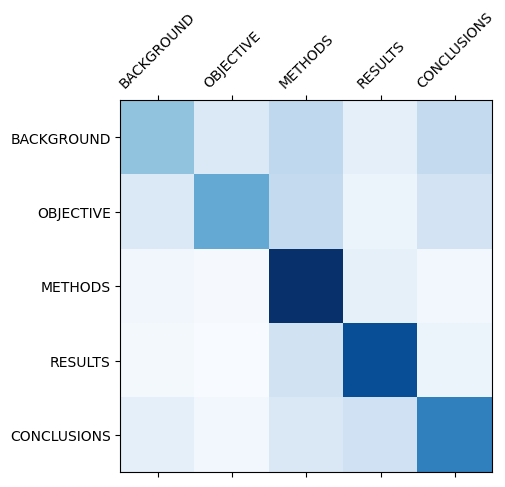

In [9]:
from sklearn.metrics import confusion_matrix

### CREATE THE CONFUSION MATRIX ###
cm = confusion_matrix(y_test, y_test_pred, normalize='true')

### PLOT IT USING plt.matshow ###
plt.matshow(cm, cmap='Blues')

### CHANGE THE TICKS FROM NUMBERS TO SECTION LABELS ###
plt.xticks(np.arange(5), sections, rotation=45)
plt.yticks(np.arange(5), sections)

plt.show()

## Steps to distribute your work as an html file:

If you're using Anaconda on your local machine:
- download your notebook as html (see `File > Download as > HTML (.html)`)

If you're using Google Colab:
- download your notebook as .ipynb (see `File > Download > Download .ipynb`)
- if you have nbconvert installed, convert it to .html and submit it in Talent LMS
- if not, you may need to place the .ipynb file in a .zip archive in order to distribute it (e.g. to upload or send via email)